In [ ]:
# 1) Setup libraries
# Clean up an unnecessary warning and make sure sklearn is present.
!pip -q uninstall -y keras-hub || true
!pip -q install -U scikit-learn

import os, sys, json, random, pathlib, shutil, itertools, time, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

print("TF version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))


TF version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 2) Global Config
PROJECT_ROOT = "/content"
DATA_ROOT    = f"{PROJECT_ROOT}/data"
RUNS_DIR     = f"{PROJECT_ROOT}/runs"
os.makedirs(DATA_ROOT, exist_ok=True); os.makedirs(RUNS_DIR, exist_ok=True)

# Use Google Drive
DATA_SOURCE_TYPE = "gdrive_folder"

GDRIVE_SOURCE_FOLDER = "/content/drive/MyDrive/MonkeySpecies.zip"

# Split the data into train/validation/test sets
NEEDS_SPLIT = True
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.70, 0.15, 0.15

# Image & training params
IMAGE_SIZE   = (224, 224)
BATCH_SIZE   = 32
EPOCHS_FE    = 10
EPOCHS_FT    = 10
LEARNING_RATE_FE = 1e-3
LEARNING_RATE_FT = 1e-4

# TF-Hub backbone
HUB_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"




In [ ]:
#  3) Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

import os, pathlib, shutil, zipfile

assert os.path.exists(GDRIVE_SOURCE_FOLDER), (
    f"GDRIVE_SOURCE_FOLDER not found: {GDRIVE_SOURCE_FOLDER}\n"
    "Open the Files sidebar to confirm the path, or adjust GDRIVE_SOURCE_FOLDER."
)
print("Using Drive folder:", GDRIVE_SOURCE_FOLDER)

Mounted at /content/drive
Using Drive folder: /content/drive/MyDrive/MonkeySpecies.zip


In [ ]:
#  4) Load Data into data/raw
import pathlib, zipfile, shutil, os

RAW_DIR  = f"{DATA_ROOT}/raw"
PREP_DIR = f"{DATA_ROOT}/prepared"
shutil.rmtree(RAW_DIR, ignore_errors=True)
shutil.rmtree(PREP_DIR, ignore_errors=True)
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PREP_DIR, exist_ok=True)

src_path = pathlib.Path(GDRIVE_SOURCE_FOLDER)
assert src_path.exists(), f"Path not found: {src_path}"

def pick_monkey_root(base_dir: pathlib.Path) -> pathlib.Path:
    cand = None
    for d in base_dir.rglob("*"):
        if d.is_dir():
            name = d.name.lower().replace(" ", "-")
            if ("monkey" in name and "species" in name) and ("10" in name or "ten" in name):
                cand = d
                break
    return cand if cand else base_dir

def copy_tree_images(src: pathlib.Path, dst: pathlib.Path):
    suffs = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".gif"}
    for p in src.rglob("*"):
        if p.is_file() and p.suffix.lower() in suffs:
            rel = p.relative_to(src)
            out = dst / rel
            out.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(p, out)

if src_path.is_file() and src_path.suffix.lower() == ".zip":
    # extract to a temp, then pick the dataset folder and copy images
    extract_dir = pathlib.Path(RAW_DIR) / "tmp_extract"
    shutil.rmtree(extract_dir, ignore_errors=True)
    with zipfile.ZipFile(src_path, "r") as zf:
        zf.extractall(extract_dir)

    monkey_root = pick_monkey_root(extract_dir)
    print("Selected images folder in ZIP:", monkey_root)
    copy_tree_images(monkey_root, pathlib.Path(RAW_DIR))

elif src_path.is_dir():
    # if parent folder contains both datasets, pick '10-monkey-species'
    monkey_root = pick_monkey_root(src_path)
    print("Selected images folder:", monkey_root)
    copy_tree_images(monkey_root, pathlib.Path(RAW_DIR))
else:
    raise ValueError(f"Unsupported input path (not a folder or .zip): {src_path}")

print("RAW_DIR ready at:", RAW_DIR)

Selected images folder in ZIP: /content/data/raw/tmp_extract
RAW_DIR ready at: /content/data/raw


In [ ]:
# 5) Prepare Dataset
# Combines train/val folders, fixes nested layouts, and re-splits into train/val/test

import os, pathlib, shutil
from sklearn.model_selection import train_test_split

assert os.path.isdir(RAW_DIR),  f"RAW_DIR not found: {RAW_DIR}"
assert os.path.isdir(PREP_DIR), f"PREP_DIR not found: {PREP_DIR}"

RAW_MAIN = pathlib.Path(RAW_DIR)
IMG_SUFFS = {".jpg",".jpeg",".png",".bmp",".gif",".tif",".tiff"}

def has_images(folder: pathlib.Path) -> bool:
    return any((folder.glob("*.jpg"))) or any((folder.glob("*.jpeg"))) or any((folder.glob("*.png"))) or \
           any((folder.glob("*.bmp"))) or any((folder.glob("*.gif"))) or any((folder.glob("*.tif"))) or \
           any((folder.glob("*.tiff")))

def find_split_dir(split_name: str) -> pathlib.Path | None:
    candidates = [d for d in RAW_MAIN.rglob("*") if d.is_dir() and d.name.lower() == split_name.lower()]
    best = None
    for d in candidates:
        class_dirs = [c for c in d.rglob("*") if c.is_dir() and any(x.suffix.lower() in IMG_SUFFS for x in c.glob("*.*"))]
        if class_dirs:
            if best is None or len(str(d)) > len(str(best)):
                best = d
    return best

# Return all class directories that actually contain images.
def find_class_dirs(split_root: pathlib.Path) -> list[pathlib.Path]:
    dirs = [c for c in split_root.rglob("*") if c.is_dir() and any(x.suffix.lower() in IMG_SUFFS for x in c.glob("*.*"))]

    leaves = []
    for d in dirs:
        child_with_imgs = any(ch.is_dir() and any(x.suffix.lower() in IMG_SUFFS for x in ch.glob("*.*")) for ch in d.iterdir() if ch.is_dir())
        if not child_with_imgs:
            leaves.append(d)
    return sorted(leaves, key=lambda p: p.name.lower())

# Copy a file and adds a number if the name already exists.
def safe_copy(src_file: pathlib.Path, dst_dir: pathlib.Path):
    dst_dir.mkdir(parents=True, exist_ok=True)
    target = dst_dir / src_file.name
    if not target.exists():
        shutil.copy2(src_file, target)
    else:
        stem, ext = src_file.stem, src_file.suffix
        k = 1
        while True:
            alt = dst_dir / f"{stem}_{k}{ext}"
            if not alt.exists():
                shutil.copy2(src_file, alt)
                break
            k += 1

# Locate training/validation folders
TRAIN_ROOT = find_split_dir("training")
VAL_ROOT   = find_split_dir("validation")

if TRAIN_ROOT is None:
    # Fallback: guess a root that has class subfolders with images
    def guess_image_root(base_dir: str) -> pathlib.Path:
        p = pathlib.Path(base_dir)
        for sub in p.rglob("*"):
            if sub.is_dir():
                subdirs = [d for d in sub.iterdir() if d.is_dir()]
                if not subdirs:
                    continue
                for d in subdirs:
                    if any(x.suffix.lower() in IMG_SUFFS for x in d.glob("*.*")):
                        return sub
        return p
    IMAGE_ROOT = guess_image_root(RAW_DIR)
    print("No explicit 'training' found. Using guessed image root:", IMAGE_ROOT)
    TRAIN_ROOT, VAL_ROOT = IMAGE_ROOT, None
else:
    print("Using training root:", TRAIN_ROOT)
    if VAL_ROOT:
        print("Using validation root:", VAL_ROOT)
    else:
        print("No explicit 'validation' found; will split from training only.")

# Detect class names
train_class_dirs = find_class_dirs(TRAIN_ROOT)
assert train_class_dirs, f"No class folders with images found under {TRAIN_ROOT}"
class_names = sorted({d.name for d in train_class_dirs})
print("Detected classes:", class_names)

# Combine train + val (if present)
COMBINED = RAW_MAIN / "monkeys_combined"
shutil.rmtree(COMBINED, ignore_errors=True)
for c in class_names:
    (COMBINED / c).mkdir(parents=True, exist_ok=True)

# Copy from training
for d in train_class_dirs:
    c = d.name
    for img in d.glob("*.*"):
        if img.suffix.lower() in IMG_SUFFS:
            safe_copy(img, COMBINED / c)

# Copy from validation
if VAL_ROOT:
    val_class_dirs = [p for p in VAL_ROOT.rglob("*") if p.is_dir() and p.name in class_names and any(x.suffix.lower() in IMG_SUFFS for x in p.glob("*.*"))]
    if not val_class_dirs:
        val_class_dirs = find_class_dirs(VAL_ROOT)
    for d in val_class_dirs:
        c = d.name if d.name in class_names else d.name
        if c not in class_names:
            continue
        for img in d.glob("*.*"):
            if img.suffix.lower() in IMG_SUFFS:
                safe_copy(img, COMBINED / c)

IMAGE_ROOT = COMBINED
print("Combined pool ready at:", IMAGE_ROOT)

# Create prepared/{train,val,test}/{class} folders
for split in ["train","val","test"]:
    for c in class_names:
        (pathlib.Path(PREP_DIR) / split / c).mkdir(parents=True, exist_ok=True)

# Split into train/val/test sets
for c in class_names:
    files = [f for f in (IMAGE_ROOT / c).glob("*.*") if f.suffix.lower() in IMG_SUFFS]
    assert files, f"No images for class '{c}' in {IMAGE_ROOT}"
    train_files, temp_files = train_test_split(files, test_size=(1 - TRAIN_RATIO), random_state=SEED, shuffle=True)
    if (VAL_RATIO + TEST_RATIO) == 0:
        val_files, test_files = [], temp_files
    else:
        val_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
        val_files, test_files = train_test_split(temp_files, test_size=val_size, random_state=SEED, shuffle=True)

    for src in train_files: safe_copy(src, pathlib.Path(PREP_DIR) / "train" / c)
    for src in val_files:   safe_copy(src, pathlib.Path(PREP_DIR) / "val" / c)
    for src in test_files:  safe_copy(src, pathlib.Path(PREP_DIR) / "test" / c)

print("Prepared dataset at:", PREP_DIR)

Using training root: /content/data/raw/tmp_extract/training/training
Using validation root: /content/data/raw/tmp_extract/validation/validation
Detected classes: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
Combined pool ready at: /content/data/raw/monkeys_combined
Prepared dataset at: /content/data/prepared


In [ ]:
# 6) Data Pipelines & Augmentation
train_dir = f"{PREP_DIR}/train"
val_dir   = f"{PREP_DIR}/val"
test_dir  = f"{PREP_DIR}/test"


# Load images and labels from folders
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)

# Check class info
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE

# Basic image augmentations for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def configure(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(tf.cast(x, tf.float32)), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

# Prepare final datasets
train_ds = configure(train_ds, augment=True)
val_ds   = configure(val_ds,   augment=False)
test_ds  = configure(test_ds,  augment=False)


Found 953 files belonging to 10 classes.
Found 207 files belonging to 10 classes.
Found 209 files belonging to 10 classes.
Classes: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
# 7) Model: Feature Extraction with MobileNetV2
# Use MobileNetV2 as a pretrained backbone
base = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # freeze base for feature extraction

# Build model
inputs  = tf.keras.Input(shape=IMAGE_SIZE + (3,), dtype="float32")
x       = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x       = base(x)
x       = tf.keras.layers.GlobalAveragePooling2D()(x)
x       = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs, name="tl_mobilenetv2_kerasapp")

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE_FE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "tl_mobilenetv2_kerasapp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 8) Callbacks & Logging
ckpt_dir = f"{RUNS_DIR}/checkpoints"; os.makedirs(ckpt_dir, exist_ok=True)

callbacks_fe = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{ckpt_dir}/best_fe.keras",
        monitor="val_accuracy",
        save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1),
    tf.keras.callbacks.CSVLogger(f"{RUNS_DIR}/history_fe.csv", append=False)
]


In [ ]:
# 9) Train: Feature-Extraction Phase
history_fe = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FE,
    verbose=1,
    callbacks=callbacks_fe
)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3840 - loss: 1.8982 - val_accuracy: 0.9227 - val_loss: 0.5658 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9312 - loss: 0.4394 - val_accuracy: 0.9517 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9810 - loss: 0.2033 - val_accuracy: 0.9614 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9902 - loss: 0.1362 - val_accuracy: 0.9662 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9883 - loss: 0.0943 - val_accuracy: 0.9662 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9975 - loss: 0.0738 - val_accuracy: 0.9758 - val_loss: 0.1117 - learning_rate: 0.0010
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9948 - loss: 0.0595 - val_accu

In [ ]:
#  10) Fine-Tuning (UNFREEZE TOP)
# Unfreeze top 20% of the MobileNetV2 backbone for fine-tuning
base = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):  # handle nested models
        base = layer
# Fallback: try to locate the MobileNetV2 backbone by name
if base is None:
    for lyr in model.layers:
        if isinstance(lyr, tf.keras.layers.Dropout):
            pass
for lyr in model.layers:
    if hasattr(lyr, "name") and "MobilenetV2" in lyr.__class__.__name__:
        base = lyr

if base is None:

    for lyr in model.layers:
        if hasattr(lyr, "_inbound_nodes"):
            pass
backbone_layers = [l for l in model.layers if l.trainable is True or l.trainable is False]

# Unfreeze last 20% of layers
n_to_unfreeze = max(1, int(0.2 * len(backbone_layers)))
for lyr in backbone_layers[-n_to_unfreeze:]:
    lyr.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE_FT),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tuning callbacks
callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{ckpt_dir}/best_ft.keras",
        monitor="val_accuracy",
        save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1),
    tf.keras.callbacks.CSVLogger(f"{RUNS_DIR}/history_ft.csv", append=False)
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    verbose=1,
    callbacks=callbacks_ft
)

model.save(f"{RUNS_DIR}/final_model.keras")


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - accuracy: 0.9989 - loss: 0.0498 - val_accuracy: 0.9758 - val_loss: 0.1001 - learning_rate: 1.0000e-04
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9993 - loss: 0.0450 - val_accuracy: 0.9758 - val_loss: 0.0974 - learning_rate: 1.0000e-04
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0400 - val_accuracy: 0.9758 - val_loss: 0.0959 - learning_rate: 1.0000e-04
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9993 - loss: 0.0409 - val_accuracy: 0.9807 - val_loss: 0.0931 - learning_rate: 1.0000e-04
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9988 - loss: 0.0371 - val_accuracy: 0.9807 - val_loss: 0.0910 - learning_rate: 1.0000e-04
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 0.9758 - val_loss: 0.0907 - learning_rate: 1.0000e-04
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.999

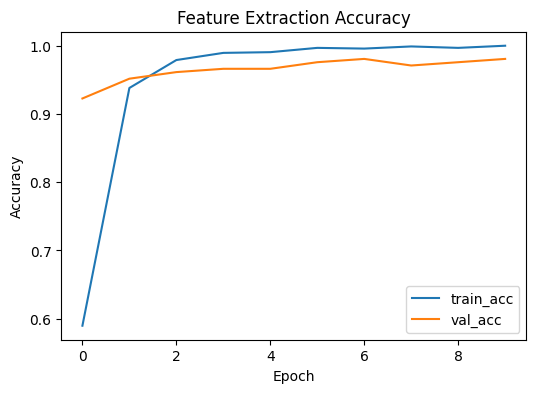

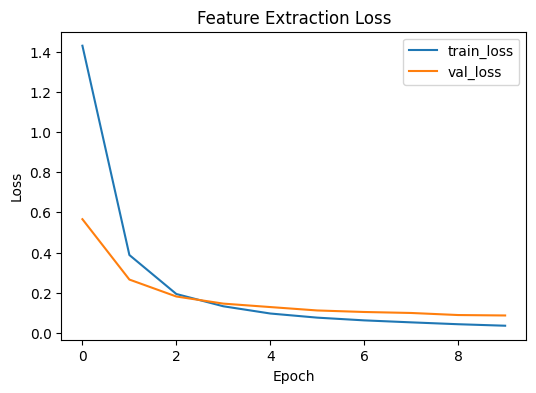

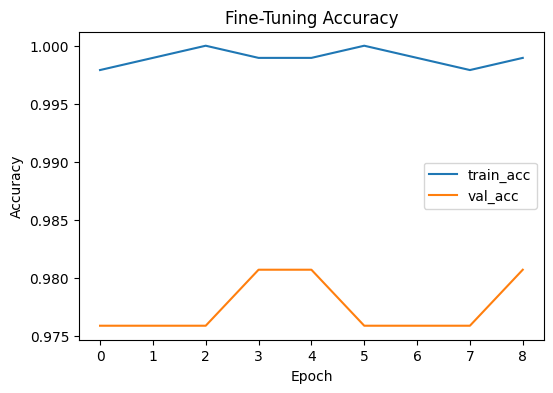

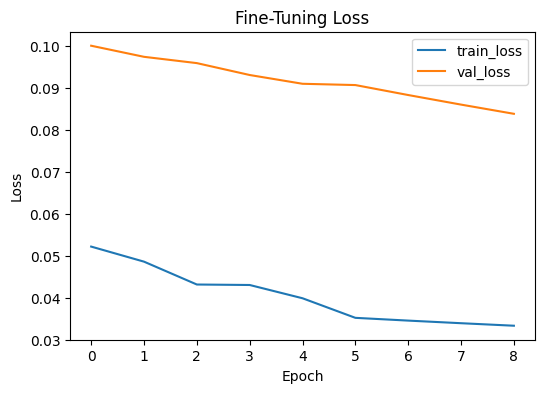

In [ ]:
# 11) History Plots (Accuracy & Loss)
def plot_history(csv_path, title_prefix):
    hist = pd.read_csv(csv_path)
    if "epoch" not in hist.columns:
        hist.insert(0, "epoch", range(len(hist)))
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(hist["epoch"], hist["accuracy"], label="train_acc")
    ax.plot(hist["epoch"], hist["val_accuracy"], label="val_acc")
    ax.set_title(f"{title_prefix} Accuracy"); ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy"); ax.legend(); plt.show()

    if "loss" in hist.columns and "val_loss" in hist.columns:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(hist["epoch"], hist["loss"], label="train_loss")
        ax.plot(hist["epoch"], hist["val_loss"], label="val_loss")
        ax.set_title(f"{title_prefix} Loss"); ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.legend(); plt.show()

plot_history(f"{RUNS_DIR}/history_fe.csv", "Feature Extraction")
plot_history(f"{RUNS_DIR}/history_ft.csv", "Fine-Tuning")


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9913 - loss: 0.0649
Test metrics [loss, acc]: [0.06468649953603745, 0.9904305934906006]
Macro F1 (test): 0.9906

Classification report:
               precision    recall  f1-score   support

          n0       1.00      1.00      1.00        20
          n1       1.00      1.00      1.00        21
          n2       1.00      0.95      0.98        21
          n3       0.96      1.00      0.98        23
          n4       1.00      1.00      1.00        20
          n5       1.00      1.00      1.00        22
          n6       1.00      1.00      1.00        20
          n7       0.96      1.00      0.98        22
          n8       1.00      0.95      0.97        20
          n9       1.00      1.00      1.00        20

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209



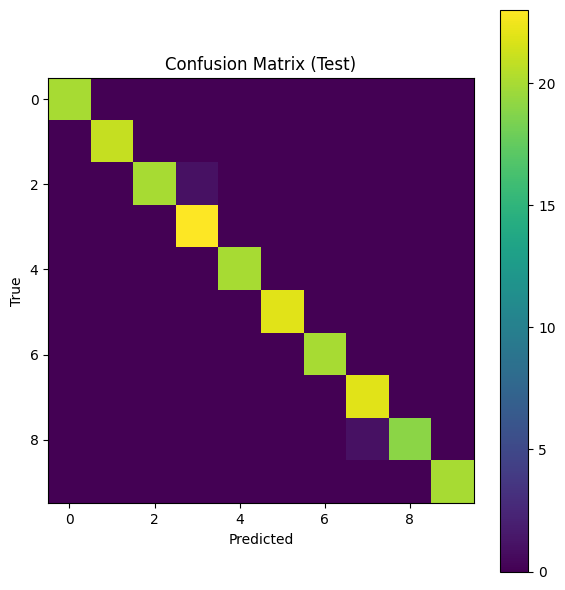

Found 209 files belonging to 10 classes.


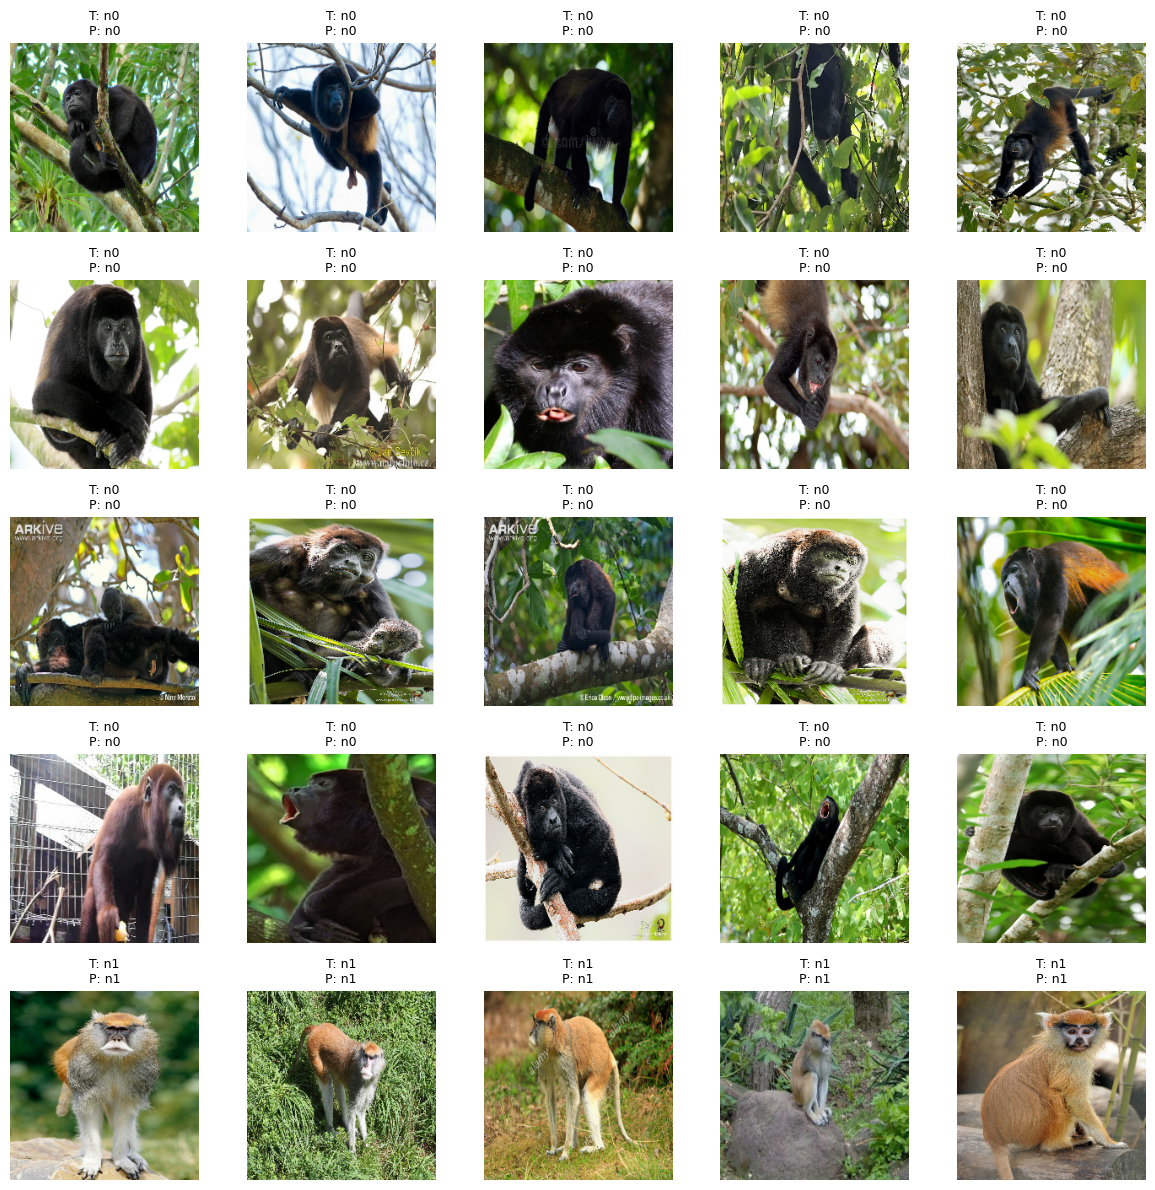

,index,true_label,pred_label,correct
0,0,n0,n0,True
1,1,n0,n0,True
2,2,n0,n0,True
3,3,n0,n0,True
4,4,n0,n0,True


In [ ]:
# 12) Test Eval + 25 Example Predictions (DATA/TRUE/PRED)
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics [loss, acc]:", test_metrics)

# Full test-set predictions for Macro-F1 and report
y_true_all, y_pred_all = [], []
for Xb, yb in test_ds:
    pb = model.predict(Xb, verbose=0)
    y_pred_all.extend(np.argmax(pb, axis=1))
    y_true_all.extend(np.argmax(yb.numpy(), axis=1))

macro_f1 = f1_score(y_true_all, y_pred_all, average="macro")
print("Macro F1 (test):", round(macro_f1, 4))
print("\nClassification report:\n",
      classification_report(y_true_all, y_pred_all, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# 25 labeled predictions grid
test_it = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)
label_map = test_it.class_names

X_25, y_25 = next(iter(test_it.unbatch().batch(25)))
probs_25 = model.predict(X_25, verbose=0)
pred_25  = tf.argmax(probs_25, axis=1).numpy()
true_25  = tf.argmax(y_25, axis=1).numpy()

rows, cols = 5, 5
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_25[i].numpy().astype("float32").astype("uint8"))
    t = label_map[int(true_25[i])]; p = label_map[int(pred_25[i])]
    plt.title(f"T: {t}\nP: {p}", fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()

# Save CSV with these examples
df25 = pd.DataFrame({
    "index": list(range(25)),
    "true_label": [label_map[int(t)] for t in true_25],
    "pred_label": [label_map[int(p)] for p in pred_25],
    "correct": (true_25==pred_25)
})
df25.to_csv(f"{RUNS_DIR}/sample25_predictions.csv", index=False)
df25.head()



In [ ]:
#  13) Simple Parameter Tuning
# Edit/expand this list as needed
sweep = [
    {"lr": 1e-3, "batch": 32, "dropout": 0.2, "epochs": 5},
    {"lr": 3e-4, "batch": 32, "dropout": 0.3, "epochs": 5},
    {"lr": 1e-4, "batch": 64, "dropout": 0.2, "epochs": 5},
]

tune_log = []
for i, cfg in enumerate(sweep, start=1):
    print(f"\n===== Iteration {i}: {cfg} =====")
    tf.keras.backend.clear_session()

    tmp_train = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=cfg["batch"], seed=SEED)
    tmp_val = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=cfg["batch"], seed=SEED)

    AUTOTUNE = tf.data.AUTOTUNE
    tmp_aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
    ])
    def cfg_pipe(ds, augment=False):
        if augment:
            ds = ds.map(lambda x,y: (tmp_aug(tf.cast(x, tf.float32)), y), num_parallel_calls=AUTOTUNE)
        else:
            ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
        return ds.cache().prefetch(AUTOTUNE)

    tmp_train = cfg_pipe(tmp_train, augment=True)
    tmp_val   = cfg_pipe(tmp_val,   augment=False)

    # Build a fresh MobileNetV2 head for each iteration
    base = tf.keras.applications.MobileNetV2(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    inputs  = tf.keras.Input(shape=IMAGE_SIZE + (3,), dtype="float32")
    x       = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x       = base(x)
    x       = tf.keras.layers.GlobalAveragePooling2D()(x)
    x       = tf.keras.layers.Dropout(cfg["dropout"])(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    tmp_model = tf.keras.Model(inputs, outputs)

    tmp_model.compile(
        optimizer=tf.keras.optimizers.Adam(cfg["lr"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    hist = tmp_model.fit(tmp_train, validation_data=tmp_val, epochs=cfg["epochs"], verbose=0)
    train_acc = float(hist.history["accuracy"][-1])
    val_acc   = float(hist.history["val_accuracy"][-1])

    tmp_test = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir, label_mode="categorical", image_size=IMAGE_SIZE, batch_size=cfg["batch"], shuffle=False)
    tmp_test = tmp_test.map(lambda x,y: (tf.cast(x, tf.float32), y))

    # Test accuracy
    test_loss, test_acc = tmp_model.evaluate(tmp_test, verbose=0)

    # Test Macro-F1
    y_true_s, y_pred_s = [], []
    for Xb, yb in tmp_test:
        pb = tmp_model.predict(Xb, verbose=0)
        y_pred_s.extend(np.argmax(pb, axis=1))
        y_true_s.extend(np.argmax(yb.numpy(), axis=1))
    f1_s = f1_score(y_true_s, y_pred_s, average="macro")

    tune_log.append({
        "Iteration": i,
        "Params": json.dumps(cfg),
        "Train_Accuracy": round(train_acc, 4),
        "Val_Accuracy":   round(val_acc, 4),
        "Test_Accuracy":  round(float(test_acc), 4),
        "Test_MacroF1":   round(float(f1_s), 4)
    })

tune_df = pd.DataFrame(tune_log)
tune_df.to_csv(f"{RUNS_DIR}/tuning_results.csv", index=False)
tune_df




===== Iteration 1: {'lr': 0.001, 'batch': 32, 'dropout': 0.2, 'epochs': 5} =====
Found 953 files belonging to 10 classes.
Found 207 files belonging to 10 classes.
Found 209 files belonging to 10 classes.

===== Iteration 2: {'lr': 0.0003, 'batch': 32, 'dropout': 0.3, 'epochs': 5} =====
Found 953 files belonging to 10 classes.
Found 207 files belonging to 10 classes.
Found 209 files belonging to 10 classes.



===== Iteration 3: {'lr': 0.0001, 'batch': 64, 'dropout': 0.2, 'epochs': 5} =====
Found 953 files belonging to 10 classes.
Found 207 files belonging to 10 classes.
Found 209 files belonging to 10 classes.


,Iteration,Params,Train_Accuracy,Val_Accuracy,Test_Accuracy,Test_MacroF1
0,1,"{""lr"": 0.001, ""batch"": 32, ""dropout"": 0.2, ""ep...",0.9895,0.9662,0.9809,0.9812
1,2,"{""lr"": 0.0003, ""batch"": 32, ""dropout"": 0.3, ""e...",0.9224,0.9710,0.9809,0.9805
2,3,"{""lr"": 0.0001, ""batch"": 64, ""dropout"": 0.2, ""e...",0.2970,0.4106,0.3876,0.3829
